Final Project: Predicting Student Performance
===
Authors: John Sabo and Michael Shimer

Goal: Make a machine learning model that can predict how well a student will do in school.

In [82]:
# IMPORTS

import ast

import numpy as np
import scipy.sparse
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.metrics import silhouette_score, adjusted_rand_score, mean_squared_error

from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer

from sklearn.decomposition import PCA

from sklearn.linear_model import SGDRegressor, Ridge, ElasticNet
from sklearn.svm import LinearSVR, SVR

from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from tensorflow import keras

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [83]:
# USEFUL METHODS

def read_student_data(filename):
    """
    Reads the CSV file from the current directory and changes all semi-colons to comas
    as well as removes all unnecessary quotes.
    """
    fixed_data = []
    file = open(filename)
    for line in file:
        line_data = line.strip().split(';')
        temp = []
        for item in line_data:
            item.strip('"')
            temp.append(item)
        fixed_data.append(temp)
    column_names = fixed_data[0]
    fixed_data.remove(fixed_data[0])
    file.close()

    return pd.DataFrame(fixed_data, columns=column_names) 


def split_labels(data, label_feature):
    """
    Split the given column of of the data, returning the full data set (without that
    feature) and the split off feature.
    """
    return data.drop(columns=label_feature), data[label_feature]


def getScores(Regressors):
    for reg in Regressors:
        score = np.sqrt(mean_squared_error(y_train, reg.predict(transformed)))
        cv_score = np.sqrt(-cross_val_score(reg, transformed, y_train, cv=3, scoring='neg_mean_squared_error').mean())
        print(str(reg) + ": " + str(score) + "\n\t\tcross val score: " + str(cv_score))

Frame the Problem and Look at the Big Picture 
===
1. Define the objective in business terms. 
    * The school is looking for a system that will predict how well a student will do to see if they can give them help earlier in the school year as opposed to later.
2. How will your solution be used? 
    * The model is going to be used to predict how well a student is doing or how well a student will do on their final grades.
    * Our solution will be used to find students who need additional help sooner rather than later.
3. What are the current solutions/workarounds (if any)? 
    * Predicting student performance is not a new idea, however, current methods used involve paper and pencil analysis.
4. How should you frame this problem (supervised/unsupervised, online/offline, ...)? 
    * Supervised - It will be a supervised learning model because we have a target feature or label.
        - The label is the students' final grade.
    * Regression - It will be a regression problem because grades are measured on a linear scale.
        - i.e. grades are '0 to 100' or 'F to A'
    * Offline - It will be offline because it will not recieve new data on a daily basis.
5. How should performance be measured? Is the performance measure aligned with the business objective? 
    * The root mean squared error will denote how close the model is to predicting the actual grade.
6. What would be the minimum performance needed to reach the business objective? 
    * To reach the business objective we will have a minimum performance requirement for the model of 10% error. In other words, the predicted final grade mnust always be within 10 points of the acutal grade.
7. What are comparable problems? Can you reuse experience or tools? 
    * Predicting an athlete performance based on factors in and off the field is a similar problem. There models that exist to predict performance of both students and athletes. Some models may exist that use some athletic data to predict the students performance. There are no tools or experience we can use to specifically help solve this problem, however, as our experience grows in Machine learning, we feel more ready for the task.
8. Is human expertise available? 
    * This project has no human expertise available.
9. How would you solve the problem manually? 
    * To solve this manually, all the features would be analyzed and given a weight based on how important each feature is determined to be. An alogrithm would be written to consider all the weights of the attributes and compute a numerical prediction for the final grade of the student.
10.  List the assumptions you (or others) have made so far. Verify assumptions if possible. 
    * So assumptions are being made against our data.

Get the Data
===

1. List the data you need and how much you need 
* The data for this project is student characteristics that will be used to predict their performance in school. This data set includes about 1000 different student samples. 
2. Find and document where you can get that data 
* The data is available on Kaggle: https://www.kaggle.com/datasets/impapan/student-performance-data-set
3. Get access authorizations
* the data is public 
4. Create a workspace (with enough storage space)
* this notebook
5. Get the data
* data is in student.csv file  
6. Convert the data to a format you can easily manipulate (without changing the data itself)
* data is loaded from the student.csv file into a pandas dataframe labeled "data"  
7. Ensure sensitive information is deleted or protected (e.g. anonymized) 
* there is no sensitive data included in this data set
8. Check the size and type of data (time series, geographical, ...) 
* The data has just over 1000 samples with 32 features each
    1. Is it a time series: Not a time series.
    2. Are any of the features not be available for the business problem? All features will be available for the business problem.
    3. Which feature(s) will be used as the target/label for the business problem? The label for the business problem is the grade for the feature "G3".
    4. Should any of the features be stratified during the train/test split to avoid sampling biases? None of the features need to be stratified.
* There are 13 numerical features and 20 categorical features.
9. Sample a test set, put it aside, and never look at it (no data snooping!) 
* train and test sets are created

In [84]:
data = read_student_data('student.csv')

train_set, test_set = train_test_split(data, test_size=.15)

X_train, y_train = split_labels(train_set, "G3")
X_test, y_test = split_labels(test_set, "G3")

# Convert labels to integers
y_train = y_train.astype(str).astype(int)
y_test = y_test.astype(str).astype(int)

X_train_copy = X_train.copy()
y_train_copy = y_train.copy()


In [85]:
data['G3'].value_counts()

10    153
11    151
13    113
12    103
14     90
15     82
8      67
9      63
0      53
16     52
17     35
18     27
7      19
6      18
5       8
19      7
20      1
4       1
1       1
Name: G3, dtype: int64

Explore the data
===
1. Copy the data for exploration, downsampling to a manageable size if necessary. 
* The data has been coppied for exploration.
2. Study each attribute and its characteristics: Name; Type (categorical, numerical, 
bounded, text, structured, ...); % of missing values; Noisiness and type of noise (stochastic, outliers, rounding errors, ...); 
Usefulness for the task; Type of distribution (Gaussian, uniform, logarithmic, ...) 
    * school: school is a categorical feature which can be one of two values (GP or MS), that define which school this data was taken from. There are almost three times as many samples for the GP school than there are for the MS school. Because future data can be from any school, this is likely not an important feature and can de dropped.
    * sex: sex refers to the gender of the student (male or female). There are about 150 more female samples than there are male samples. This could be an important feature for this project.
    * age: age is a numerical category refers to the age of the student. This feature is about normally distributed and there are no outliers. This could be an important feature for the model.
    * address: address is a categorical feature which can be one of two values (U for urban or R for rural). There are about three times as many urban addresses than rural addresses. This could be an important feature for the model.
    * famsize: famsize is a categroical feature which has two possible values (greater than 3 or less than or equal to 3). There are about three times as many greater than 3 famsizes than there are less than or equal to 3. This might be an important feature for the model.
    * Pstatus: Pstatus is a categorical feature which represents parent's marital status. This can be either "T" for together or "A" for apart. There are about 9 times as many together values than there are apart values. This could be an important feature for the model. 
    * Medu: Medu represents the mothers education status. It is a numerical value ranging from 0 to 4: 0 - none,  1 - primary education (4th grade), 2 - 5th to 9th grade, 3 - secondary education or 4 - higher education. This feature is uniformly distributed and is probably an important feature for this model.
    * Fedu: Fedu represents the fathers education status. It is a numerical value ranging from 0 to 4: 0 - none,  1 - primary education (4th grade), 2 - 5th to 9th grade, 3 - secondary education or 4 - higher education. This feature is uniformly distributed and is probably an important feature for this model.
    * Mjob: Mjob is a categorical feature which represents the mothers career field. The possible values are: "teacher", "health" care related, civil "services" (e.g. administrative or police), "at_home" or "other". This feature is uniformly distributed, but "health" has a lot fewer samples than the rest. This could be an important feature for this model.
    * Fjob: Fjob is a categorical feature which represents the fathers career field. The possible values are: "teacher", "health" care related, civil "services" (e.g. administrative or police), "at_home" or "other". The most frequent value is "other" while the least frequent value is "health". This could be an important feature for this model.
    * reason: reason is the reason why the student chose the school. This is a categorical feature with the possible values: close to "home", school "reputation", "course" preference or "other". The most popular value is "course" while the least common feature is "other". This could be an important feature to our model.
    * guardian: guardian refers to who the students guardian is. This is a categorical feature which has the possible values: "mother", "father" or "other". Mother is about 3 times as common as father while other was the least common. This could be an important feature to the model.
    * traveltime: traveltime refers to how long the student has to travel to school. This is a numerical feature which has the possible values: 1 - <15 min., 2 - 15 to 30 min., 3 - 30 min. to 1 hour, or 4 - >1 hour. The most common value is 1 and they get less common as the distance increases. This could be an important feature to the model.
    * studytime: studytime refers to the amount of time a student spends studying per week. This is a numerical feature with the possible values: 1 - <2 hours, 2 - 2 to 5 hours, 3 - 5 to 10 hours, or 4 - >10 hours. This feature is about normally distributed and is an important feature to the model.
    * failures: failures corresponds to the number of classes failed in the past by the students. This is a numerical feature which correlates to the number of failures but is maxed out at 4 failures. No failures is the most common and it gets less common as the number of failures goes up. This is an important feature to the model. 
    * schoolsup: schoolsup is a categorical feature which defines whether or not the student has extra educational support. There about 9 times as many no's as there are yes's. This could be an important feature to the model.
    * famsup: famsup is a categorical feature which defines whether or not the student has family educational support. There about 9 times as many no's as there are yes's. This could be an important feature to the model. The distribution is about 6 to 4 ratio for yes to no. This could be an important feature to the model.
    * paid: paid is a categorical feature which determines whether or not the student paid for extra classes in a subject (yes or no). There about 4 times as many students who have not paid for extra classes as there are students who have. This could be an important feature.
    * activities: activities is a categorical feature which defines whether or not the student participates in extra-caricular activities at school (yes or no). This feature is uniformly split yes and no. This could be an important feature.
    * nursery: nursery is a categorical feature that defines whether or not the student attended nursery school (yes or no). About four times as many students did attend nursery school than didn't. This could be an important feature.
    * higher: higher is a categorical feature that defines whether or not the student plans to get a higher education (yes or no). About ten times as many students want to get a higher education than those that don't. This could be an important feature. 
    * internet: internet is a categorical feature that defines whether or not the student has internet access at home (yes or no). About four times as many students have internet at home than those that don't. This could be an important feature.
    * romantic: romantic is a categorical feature that determines if a student is in a romantic relationship (yes or no). About two times as many students are not in a relationship than those who are in a relationship. This might not be an important feature but will remain in the data in case it is important.
    * famrel: famrel is a numerical feature that correlates to the quality of the student's family relationship. Famrel is scored from 1 - very bad to 5 - excellent. The most common score is 4 while the rest of the scores are much less common. This could be an important feature to the model.
    * freetime: freetime is a numerical feature that correlates to how much freetime a student has after school. Freetime is scored from 1 - very low to 5 - very high. Freetime is normally distributed and could be important to the model.
    * goout: goout is a numerical feature that correlates to how often the student goes out with friends. Goout is scored from 1 - very low to 5 - very high. Goout is normally distributed and could be an important feature to the model.
    * Dalc: Dalc is a numerical feature that correlates to the amount of alcohol the student consumes during the week. Dalc is scored from 1 - very low to 5 - very high. Dalc has a log normal distribution and might be important to the model.
    * Walc: Walc is a numerical feature that correlates to the amount of alcohol the student consumes during the weekend. Walc is scored from 1 - very low to 5 - very high. Lower values of Walc are more common and get less frequent as the value goes up. Walc might be important to the model.
    * health: health is a numerical feature that correlates to the quality of health of the student. Health is scored from 1 - very bad to 5 - very good. Health is uniformly distributed except a score of 5 is about twice as common as the rest of the scores. This could be an important feature to the model.
    * absences: absences is a numerical feature that defines how many absences the student has from 0 to 93. Absences has a log normal distribution and could be an important featrue to the model.
    * G1: G1 is a numerical feature that correlates to the students grades for the first period. G1 is normally distributed. This feature will be dropped because it will not be applicable to the buisness problem.
    * G2: G2 is a numerical feature that correlates to the students grades for the second period. G2 is normally distributed. This feature will be dropped because it will not be applicable to the buisness problem.
    * G3: G2 is a numerical feature that correlates to the students fianl grade. G3 is normally distributed and is the target attribute for the model. 
3. For supervised learning tasks, identify the target attribute(s) 
* The target attribute for this project is the G3 feature which is a students final grade. 
4. Visualize the data 
* Charts and tables are displayed below to visualize the types of features and the distribution of their values.
5. Study the correlations between attributes 
    * Medu and Fedu have a high positive correlation
    * Age and failures are positively correlated
    * Studytime is negatively correlated with Walc, Dalc and failures
    * Freetime is positively correlated with goout
    * Walc and Dalc are positively correlated
6. Study how you would solve the problem manually 
* To solve this problem manually, we would select features that we found most important (studytime, Medu, Fedu, failures, schoolsup, freetime, goout, famrel). These are in order from most important to less important, however we deem them all to be important. Each feature would be given a weight based on their importance. We would write an algorithm to consider the values of each students features and weigh them accordingly to determine an estimate at what the student's final grade would be based on the grades associated with previous student data.
7. Identify the promising transformations you may want to apply 
* All of the categorical data is going to be one hot encoded
* The features Dalc and absences features have a log distribution and should be transformed
* The school, G1 and G2 grade features will be dropped.
8. Identify extra data that would be useful (go back to “Get the Data”) 
* There is no extra data that has been deemed useful.
9. Document what you have learned 
    * This is a supervised regression learning model with the target attribute being G3, the students final grade.
    * There is no missing data in any of the samples or features
    * The school, G1 and G2 grade features will be dropped
    * All of the categorical data should be one hot encoded
    * The features Dalc and absences features have a log distribution and should be transformed

In [86]:
X_train.describe()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2
count,887,887,887,887,887,887,887,887,887,887,887,887,887,887,887,887,887,887,887,887,887,887,887,887,887,887,887,887,887,887,887,887
unique,2,2,8,2,2,2,5,5,5,5,4,3,4,4,4,2,2,2,2,2,2,2,2,5,5,5,5,5,5,33,17,16
top,"""GP""","""F""",16,"""U""","""GT3""","""T""",4,2,"""other""","""other""","""course""","""mother""",1,2,0,"""no""","""yes""","""no""","""no""","""yes""","""yes""","""yes""","""no""",4,3,3,1,1,5,0,"""10""","""12"""
freq,658,510,234,657,620,788,261,278,338,503,365,608,533,422,732,787,543,698,455,714,810,705,571,434,349,283,625,342,334,307,124,114


In [87]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 887 entries, 47 to 814
Data columns (total 32 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      887 non-null    object
 1   sex         887 non-null    object
 2   age         887 non-null    object
 3   address     887 non-null    object
 4   famsize     887 non-null    object
 5   Pstatus     887 non-null    object
 6   Medu        887 non-null    object
 7   Fedu        887 non-null    object
 8   Mjob        887 non-null    object
 9   Fjob        887 non-null    object
 10  reason      887 non-null    object
 11  guardian    887 non-null    object
 12  traveltime  887 non-null    object
 13  studytime   887 non-null    object
 14  failures    887 non-null    object
 15  schoolsup   887 non-null    object
 16  famsup      887 non-null    object
 17  paid        887 non-null    object
 18  activities  887 non-null    object
 19  nursery     887 non-null    object
 20  higher   

In [88]:
for column in X_train.columns:
            if(X_train[column][0][0] != '"'):
                X_train[column] = X_train[column].astype(str).astype(int)

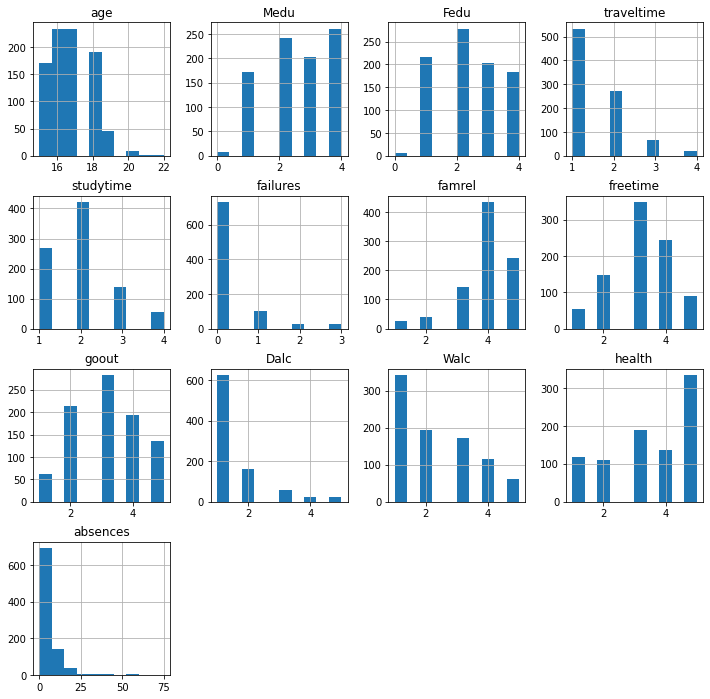

In [89]:
X_train.hist(figsize=(12, 12), bins=10);

<AxesSubplot:>

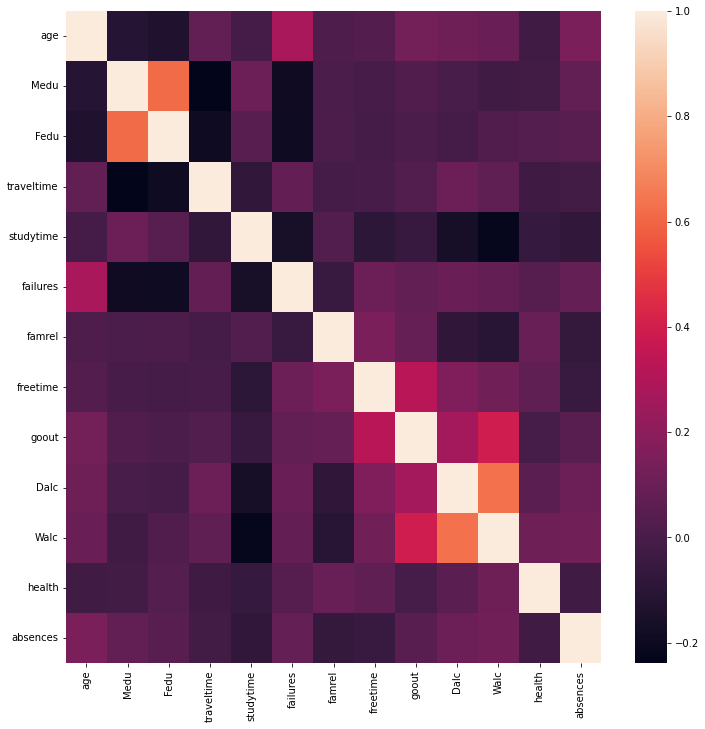

In [90]:
plt.figure(figsize=(12,12))
sns.heatmap(X_train.corr())

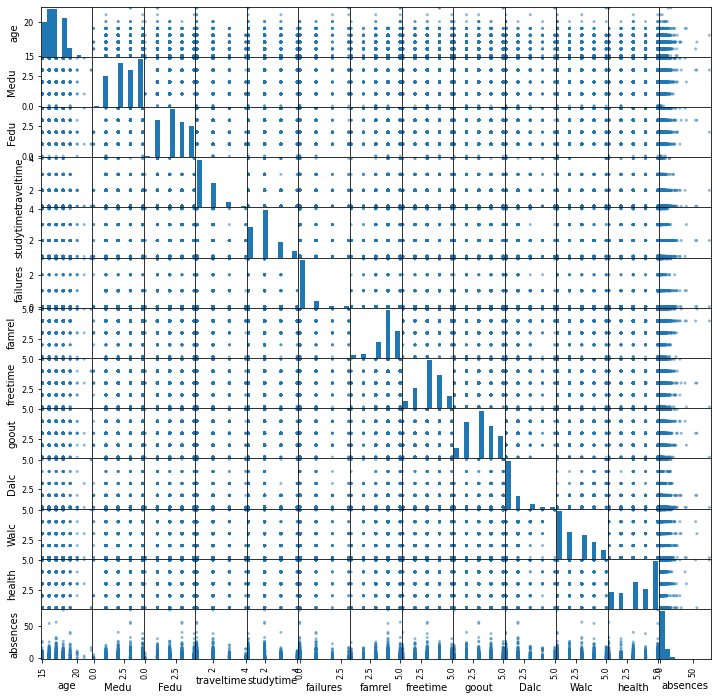

In [91]:
pd.plotting.scatter_matrix(X_train, figsize=(12,12));

Prepare the Data
===

In [92]:
# Cell for preprocessor classes

class RemoveUnwantedFeatures(BaseEstimator, TransformerMixin):
    """
    Drops the unwanted features. Since our target feature is the final grade we will not need
    the first and second semester grades. So this will remove "G1" and "G2".
    """
    def __init__(self, features=None):
        super().__init__()
        self.features = features

    def fit(self, X, y=None, **kwargs):
        
        return self

    def transform(self, X): return X.drop(columns=self.features)


class ConvertNumbersToIntegers(BaseEstimator, TransformerMixin):
    """
    Converts all numerical objects to objects of type int.
    """
    def __init__(self):
        super().__init__()

    def fit(self, X, y=None, **kwargs): return self

    def transform(self, X):
        for column in X.columns:
            if(X[column][0][0] != '"'):
                X[column] = X[column].astype(str).astype(int)
        return X


class LogTransformData(BaseEstimator, TransformerMixin):
    """
    Takes the log of features to convert them from a log distribution to a normal distribution
    """
    def __init__(self, features=None):
        super().__init__()
        self.features = features

    def fit(self, X, y=None, **kwargs): return self

    def transform(self, X):
        for feature in self.features:
            X[feature] = np.log(X[feature]+1)
        return X


class ConvertToDataFrame(BaseEstimator, TransformerMixin):
    """
    After running oneHotEncoder the DateFrame is converted to a numpy array, this function converts the 
    numpy array back into a DataFrame
    """
    def __init__(self):
        super().__init__()

    def fit(self, X, y=None, **kwargs): return self

    def transform(self, X):
        X = pd.DataFrame(X, columns=["school_GP", "school_MS", "sex_F", "sex_M", "address_rural", "address_urban", "famsize_GT3", "famsize_LT3", "Pstatus_apart", "Pstatus_together",
    "Mjob_home", "Mjob_health", "Mjob_other", "Mjob_services", "Mjob_teacher", "Fjob_home", "Fjob_health", "Fjob_other", "Fjob_services", "Fjob_teacher",
    "guardian_father", "guardian_mother", "guardian_other", "reason_course", "reason_other", "reason_home", "reason_reputation", "schoolsup_no", "schoolsup_yes",
    "famsup_no", "famsup_yes", "paid_no", "paid_yes", "activities_no", "activites_yes", "nursery_no", "nursery_yes", "higher_no", "higher_yes",
    "internet_no", "internet_yes", "romantic_no", "romantic_yes", "age", "Medu", "Fedu", "traveltime", "studytime", "failures", "famrel", "freetime",
    "goout", "Dalc", "Walc", "health", "absences"])
        return X


In [93]:
X_train = X_train_copy
y_train = y_train_copy

preprocessor = Pipeline([

    ('drop_features', RemoveUnwantedFeatures(features=["G1", "G2"])),
    ('convert_to_int', ConvertNumbersToIntegers()),
    ('log_transform', LogTransformData(features=["traveltime", "failures", "Dalc", "absences"])),

    ('column_transform_one_hot', ColumnTransformer(transformers=[
        ('one_hot_encoder', OneHotEncoder(), ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'guardian', 'reason',
        'schoolsup', 'famsup', 'paid', 'activities','nursery', 'higher', 'internet', 'romantic']),
    ], remainder='passthrough')),
    ('scaler', MinMaxScaler()),
    ('convert_to_dataframe', ConvertToDataFrame())

])


transformed = preprocessor.fit_transform(X_train, y_train)

Short-list Promising
===

In [96]:
# fit the short listed sklearn models with basic parameters

ridge = Ridge()
ridge.fit(transformed, y_train)

eNet = ElasticNet()
eNet.fit(transformed, y_train)

lSvr = LinearSVR()
lSvr.fit(transformed, y_train)

svr = SVR()
svr.fit(transformed, y_train)

sgd = SGDRegressor()
sgd.fit(transformed, y_train)

dt = DecisionTreeRegressor()
dt.fit(transformed, y_train)

rf = RandomForestRegressor()
rf.fit(transformed, y_train)

ext = ExtraTreesRegressor()
ext.fit(transformed, y_train)

gbr = GradientBoostingRegressor()
gbr.fit(transformed, y_train)
reg_list = [ridge, eNet, lSvr, svr, sgd, dt, rf, ext, gbr]
getScores(Regressors=reg_list)

Ridge(): 3.315233281742406
		cross val score: 3.5327691946753994
ElasticNet(): 3.8857138753026192
		cross val score: 3.887445800000383
LinearSVR(): 3.41633980826505
		cross val score: 3.5442667630898863


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


SVR(): 3.2477363435916664
		cross val score: 3.5551542793890625
SGDRegressor(): 3.3266793846750136
		cross val score: 3.533710918012859
DecisionTreeRegressor(): 0.37162612286718255
		cross val score: 4.535602953497903
RandomForestRegressor(): 1.2553481505783306
		cross val score: 3.375307109052214
ExtraTreesRegressor(): 0.37162612286718255
		cross val score: 3.620609139115974
GradientBoostingRegressor(): 2.4872965143653407
		cross val score: 3.454832617635298


Short List of Models:
* We tried all possible regressors from sklearn: Ridge, ElasticNet, LinearSVR, SVR, SGDRegressor, DecisionTreeRegressor, RandomForestRegressor, ExtraTreesRegressor, GradienBoostingRegressor with base parameters
* With base parameters, all of the regressors are performing about the same and none of them perform particularly well with out tuning the hyperparameters

In [110]:
# analyze hyperparameters

ridge = Ridge(alpha=.01)
ridge.fit(transformed, y_train)

eNet = ElasticNet(alpha=0.01, l1_ratio=.5)
eNet.fit(transformed, y_train)

lSvr = LinearSVR()
lSvr.fit(transformed, y_train)

svr = SVR()
svr.fit(transformed, y_train)

sgd = SGDRegressor()
sgd.fit(transformed, y_train)

dt = DecisionTreeRegressor()
dt.fit(transformed, y_train)

rf = RandomForestRegressor()
rf.fit(transformed, y_train)

ext = ExtraTreesRegressor()
ext.fit(transformed, y_train)

gbr = GradientBoostingRegressor()
gbr.fit(transformed, y_train)
reg_list = [ridge, eNet, lSvr, svr, sgd, dt, rf, ext, gbr]
getScores(Regressors=reg_list)

Ridge(alpha=0.01): 3.315095750781199
		cross val score: 3.537943366589929
ElasticNet(alpha=0.01, l1_ratio=0.7): 3.3202016538203387
		cross val score: 3.5135281644267655
LinearSVR(): 3.416100688488254
		cross val score: 3.5433157274394844


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


SVR(): 3.2477363435916664
		cross val score: 3.5551542793890625
SGDRegressor(): 3.3257852999299504
		cross val score: 3.5459444505984825
DecisionTreeRegressor(): 0.37162612286718255
		cross val score: 4.589611290593998
RandomForestRegressor(): 1.2510424848023014
		cross val score: 3.3467768660482595
ExtraTreesRegressor(): 0.37162612286718255
		cross val score: 3.609036518230081
GradientBoostingRegressor(): 2.4872965143653407
		cross val score: 3.453858797594723


Hyperparameter Anylysis:
* Ridge: increasing and decreasing alpha does not affect performance much, ridge might not be a good regressor for this model
* ElasticNet: decreasing alpha improves the score, changing the l1 ratio does not improve the score
* LinearSVC: 
* SVR:
* SGDRegressor:
* DecisionTreeRegressor:
* RandomForestRegressor:
* ExtraTreesRegressor:
* GradientBoostingRegressor:

In [95]:
# try neural net

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=X_train[0].shape, name='input')),
model.add(keras.layers.Dense(100, activation='relu', name="hidden_1")),
for i in range(2,11):
    model.add(keras.layers.Dense(20, activation='relu', name=f"hidden_{i}")),
model.add(keras.layers.Dense(10, activation=keras.activations.softmax, name="output")) # ten outputs for 10 different classes

# TODO: Compile the model using the SGD optimizer, categorical cross-entropy loss, and an accuracy metric
model.compile(optimizer=keras.optimizers.SGD(learning_rate=0.01), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# TODO: Fit the model to the training data using 10 epochs
model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))

# TODO: Evaluate the testing performance
model.evaluate(X_test, y_test)

2022-04-29 16:05:17.994491: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


KeyError: 0